# Identifying duplicate questions
 
## Data preprocessing and modeling (using TensorFlow and Keras)

Over 100 million people visit Quora every month, and many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. 

The goal is to identify whether two questions are duplicates or not (binary classification problem).

#### Data:

Quora dataset contains pairs of questions ('question1' and 'question2') and labels for each pair (column 'is_duplicate').

The dataset had been split into training, validation and test sets (see the Jupyter notebook quora_data_analysis.ipynb).

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
import pandas as pd
import numpy as np

I run the notebook in Google Colab and read the data from Google Drive.

Connect to Google Drive:

In [5]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


## 1. Load the data and convert to tensors

The function below reads the dataset into a pandas DataFrame and convert the columns 'question1', 'question2' and 'is_duplicate' to tensors:

In [90]:
def dataset_to_tensors(filepath):
    df = pd.read_csv(filepath)

    q1_list = df['question1'].tolist()
    q2_list = df['question2'].tolist()
    y_list = df['is_duplicate'].tolist()

    tensor_q1 = tf.constant(q1_list)
    tensor_q2 = tf.constant(q2_list)
    tensor_y = tf.constant(y_list)

    return [tensor_q1, tensor_q2], tensor_y

Load and preprocess the training, validation and test sets:

In [91]:
train_tensors = dataset_to_tensors('My Drive/quora/train_set.csv')
val_tensors = dataset_to_tensors('My Drive/quora/val_set.csv')
test_tensors = dataset_to_tensors('My Drive/quora/test_set.csv')

A list containing 2 tensors - for 'question1' and for 'question2' (training data):

In [101]:
train_tensors[0]

[<tf.Tensor: shape=(226400,), dtype=string, numpy=
 array([b'How do I determine the resale value of my iPad?',
        b'What are the best methamatics books for GATE ECE branch?',
        b'If the total cost of three books and four pens are Rs. 520 and the cost of one book is twice as much as a pen, what is the cost of one pen?',
        ..., b'What does the world not know about India and why?',
        b'What supplements can help me build muscle and burn fat?',
        b'What happens if u delete .misc files in android?'], dtype=object)>,
 <tf.Tensor: shape=(226400,), dtype=string, numpy=
 array([b'How do I determine the resale value for my home?',
        b'What is the best book for GATE for the ECE Branch?',
        b'The total cost of three books and four pens is Rs 520.The cost of one book is twice as much as a pen. What is the cost of one pen?',
        ..., b'What does the world not know about India?',
        b'What is a good way to burn fat while building muscle?',
        b'Wh

The tensor for target (training data):

In [102]:
train_tensors[1]

<tf.Tensor: shape=(226400,), dtype=int32, numpy=array([0, 0, 1, ..., 0, 0, 0], dtype=int32)>

Shape of the tensor for 'question1' (training data):

In [94]:
train_tensors[0][0].shape

TensorShape([226400])

Shape of the tensor for 'question1' (validation data):

In [95]:
val_tensors[0][0].shape

TensorShape([97029])

Shape of the tensor for 'question1' (test data):

In [96]:
test_tensors[0][0].shape

TensorShape([80858])

# 2. Build a Keras Model

The model takes two inputs: a tensor for 'question1' and a tensor for 'question2'.

In the model, I used a pretrained sentence embedding module from TF Hub (nnlm-en-dim-50, version 1) to encode questions into sentence embeddings. 

The `hub.KerasLayer` downloads the module with its pretrained weights. This module parses the string and embeds each word using an embedding matrix that was pretrained on the Google News 7B corpus. Then it computes the sentence embedding (the mean of word embeddings multiplied by the square root of the number of words in the sentence). 

As a result, each question is encoded as a 50-dimensional vector.

Inputs with 'question1' and 'question2' are encoded separately, and then two outputs with sentence embeddings are concatenated.

After that, two simple Dense layers are added. The output is a prediction whether two questions are duplicates.

#### Create a Keras model (using the Functional API):

In [97]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [98]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate
import tensorflow_hub as hub

q1_input = Input(shape=[], dtype=tf.string, name='q1_input')
q2_input = Input(shape=[], dtype=tf.string, name='q2_input')

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2",
                            output_shape=[50], input_shape=[], dtype=tf.string)
 
q1_encoded = hub_layer(q1_input)
q2_encoded = hub_layer(q2_input)

concat_inputs = concatenate([q1_encoded, q2_encoded])

hidden_layer = Dense(128, activation='relu')(concat_inputs)
outputs = Dense(1, activation='sigmoid')(hidden_layer)
    
model = Model(inputs=[q1_input, q2_input], outputs=outputs)

In [99]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 q1_input (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 q2_input (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, 50)           48190600    ['q1_input[0][0]',               
                                                                  'q2_input[0][0]']               
                                                                                                  
 concatenate (Concatenate)      (None, 100)          0           ['keras_layer[0][0]',        

In [100]:
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

#### Train the model (pass in the training and validation data):

In [103]:
h1 = model.fit(train_tensors[0], train_tensors[1], epochs=10, validation_data=val_tensors)

Epoch 1/10
7075/7075 [==============================] - 72s 10ms/step - loss: 0.5565 - accuracy: 0.7056 - val_loss: 0.5212 - val_accuracy: 0.7283
Epoch 2/10
7075/7075 [==============================] - 73s 10ms/step - loss: 0.5061 - accuracy: 0.7385 - val_loss: 0.5052 - val_accuracy: 0.7382
Epoch 3/10
7075/7075 [==============================] - 71s 10ms/step - loss: 0.4904 - accuracy: 0.7495 - val_loss: 0.4982 - val_accuracy: 0.7435
Epoch 4/10
7075/7075 [==============================] - 71s 10ms/step - loss: 0.4812 - accuracy: 0.7568 - val_loss: 0.4936 - val_accuracy: 0.7472
Epoch 5/10
7075/7075 [==============================] - 69s 10ms/step - loss: 0.4747 - accuracy: 0.7598 - val_loss: 0.4955 - val_accuracy: 0.7486
Epoch 6/10
7075/7075 [==============================] - 69s 10ms/step - loss: 0.4694 - accuracy: 0.7642 - val_loss: 0.4917 - val_accuracy: 0.7480
Epoch 7/10
7075/7075 [==============================] - 68s 10ms/step - loss: 0.4648 - accuracy: 0.7678 - val_loss: 0.4896 -

After training for 10 epochs:

- Training accuracy = 77.4%

- Validation accuracy = 75.4%

#### Plot training and validation loss:

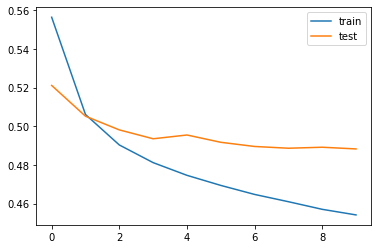

In [105]:
from matplotlib import pyplot as plt

# plot history
plt.plot(h1.history['loss'], label='train')
plt.plot(h1.history['val_loss'], label='test')
plt.legend()
plt.show()

#### Plot training and validation accuracy:

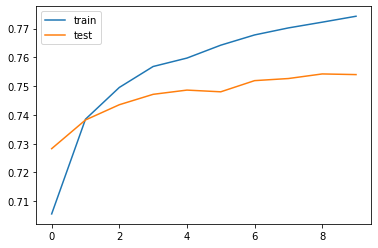

In [106]:
plt.plot(h1.history['accuracy'], label='train')
plt.plot(h1.history['val_accuracy'], label='test')
plt.legend()
plt.show()

#### Evaluate the model on the test set:

In [108]:
model.evaluate(test_tensors[0], test_tensors[1])

2527/2527 [==============================] - 16s 6ms/step - loss: 0.4872 - accuracy: 0.7558


[0.48716261982917786, 0.755794107913971]

Accuracy for the test set is about 75.6%.

#### Save the model:

In [110]:
model.save('My Drive/quora/model_1_dense')

INFO:tensorflow:Assets written to: My Drive/quora/model_1_dense/assets


INFO:tensorflow:Assets written to: My Drive/quora/model_1_dense/assets


Next steps: 
- Probably it would be good to continue training for more epochs and check the results.
- Try hyperparameter tuning.